# The Random Jazz Forest

Welcome to my Econ 213R Project! I wanted to do something that tied in many of the aspects and models we learned this semester with an emphasis on music. The idea of recommender systems got me interested in making a "better" way for streaming services like Spotify, Apple Music, and Pandora to recommend music to their listeners. The data wa spulled from a playlist I made on Spotify using 100 Jazz songs that I liked and 25 Jazz songs I did not like. Spotify uses a system to organize and classify their songs using "song features" which include features such as: danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, and time signature. There are a few others, but these will be the features of focus for ths project. 

Information about what the features mean can be found here:
https://beta.developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

To be able to extract song features using your own Spotify account:
https://beta.developer.spotify.com/console/get-audio-features-track/?id=06AKEBrKUckW0KREUWRnvT

In [1]:
from IPython.display import Image
Image(url= "https://www.freejazzlessons.com/wp-content/uploads/2012/02/jazz-band.jpg")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
%matplotlib inline

from sklearn.linear_model import SGDRegressor, ElasticNetCV, LogisticRegression
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

We are starting our code with just importing some basic programs and some complex programs we will need in order to construct our model later on. These features allow us to use models such as Logistic Regression, Nearest Neighbors, Naive Bayes, Decision Trees, and ultimately, the random forest. 

# The Data:

In [3]:
train_location = "/Users/joshuamotley/Desktop/Econ213R/Train_Data_Music_Project_2.csv"
test_location = "/Users/joshuamotley/Desktop/Econ213R/Test_Music_Data.csv"

train = pd.read_csv(train_location)
test = pd.read_csv(test_location)

In [4]:
train.head(5)

,likeability,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,1,0.449,0.603,2,-13.166,0,0.0615,0.595,0.00789,0.0237,0.713,77.659,4
1,1,0.430,0.533,0,-10.489,1,0.0585,0.582,0.13200,0.0896,0.676,106.916,4
2,1,0.468,0.305,10,-12.235,0,0.0364,0.938,0.20500,0.3570,0.283,110.130,4
3,1,0.358,0.631,5,-9.326,0,0.0586,0.193,0.00000,0.3050,0.691,86.933,4
4,1,0.516,0.696,5,-9.016,1,0.0290,0.583,0.02220,0.1060,0.634,105.879,4


In [5]:
train.isnull().sum()

likeability         0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
dtype: int64

At this point, we have uploaded our data which was entered manually from the Spotify Developer App into Excel and then saved as a csv file. We have displayed a few samples just to show what some of the features look like, we can see already that we have both categorical data and binary data. While we entered in all of the data by hand, we just want to make sure there are no missing values. Knowing now that there are no missing values, this will make our model run smoother since we will not have to add in any missing information. 

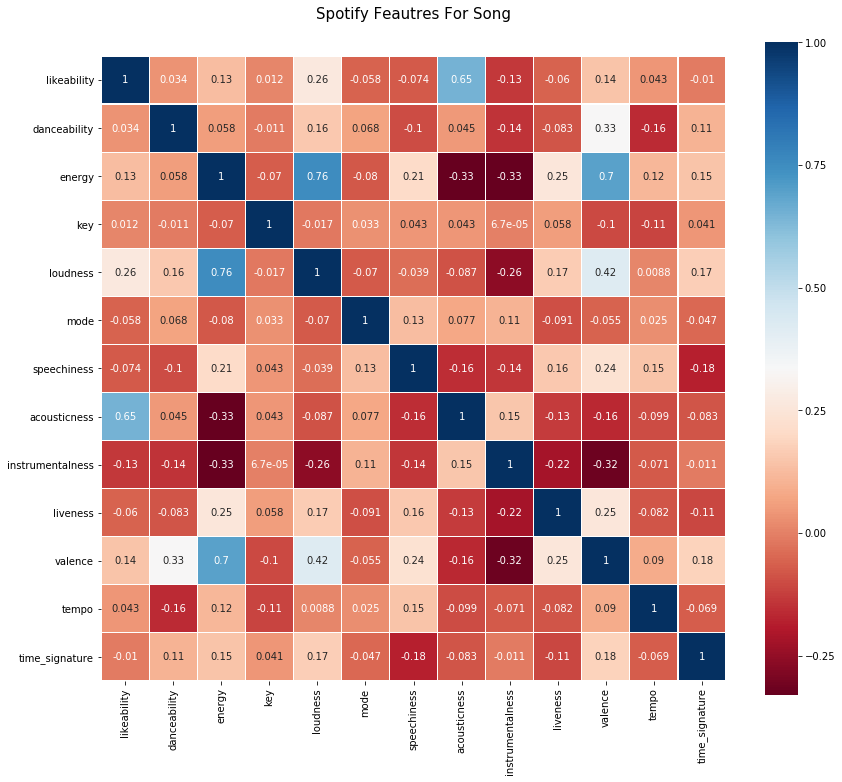

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Spotify Feautres For Song', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
           square=True, cmap=colormap, linecolor='white', annot=True)

This scale above is a heat scale to show us which features are correlated with one another. 

Text(0.5,1,'Distribution of Likeability, (1 = Liked)')

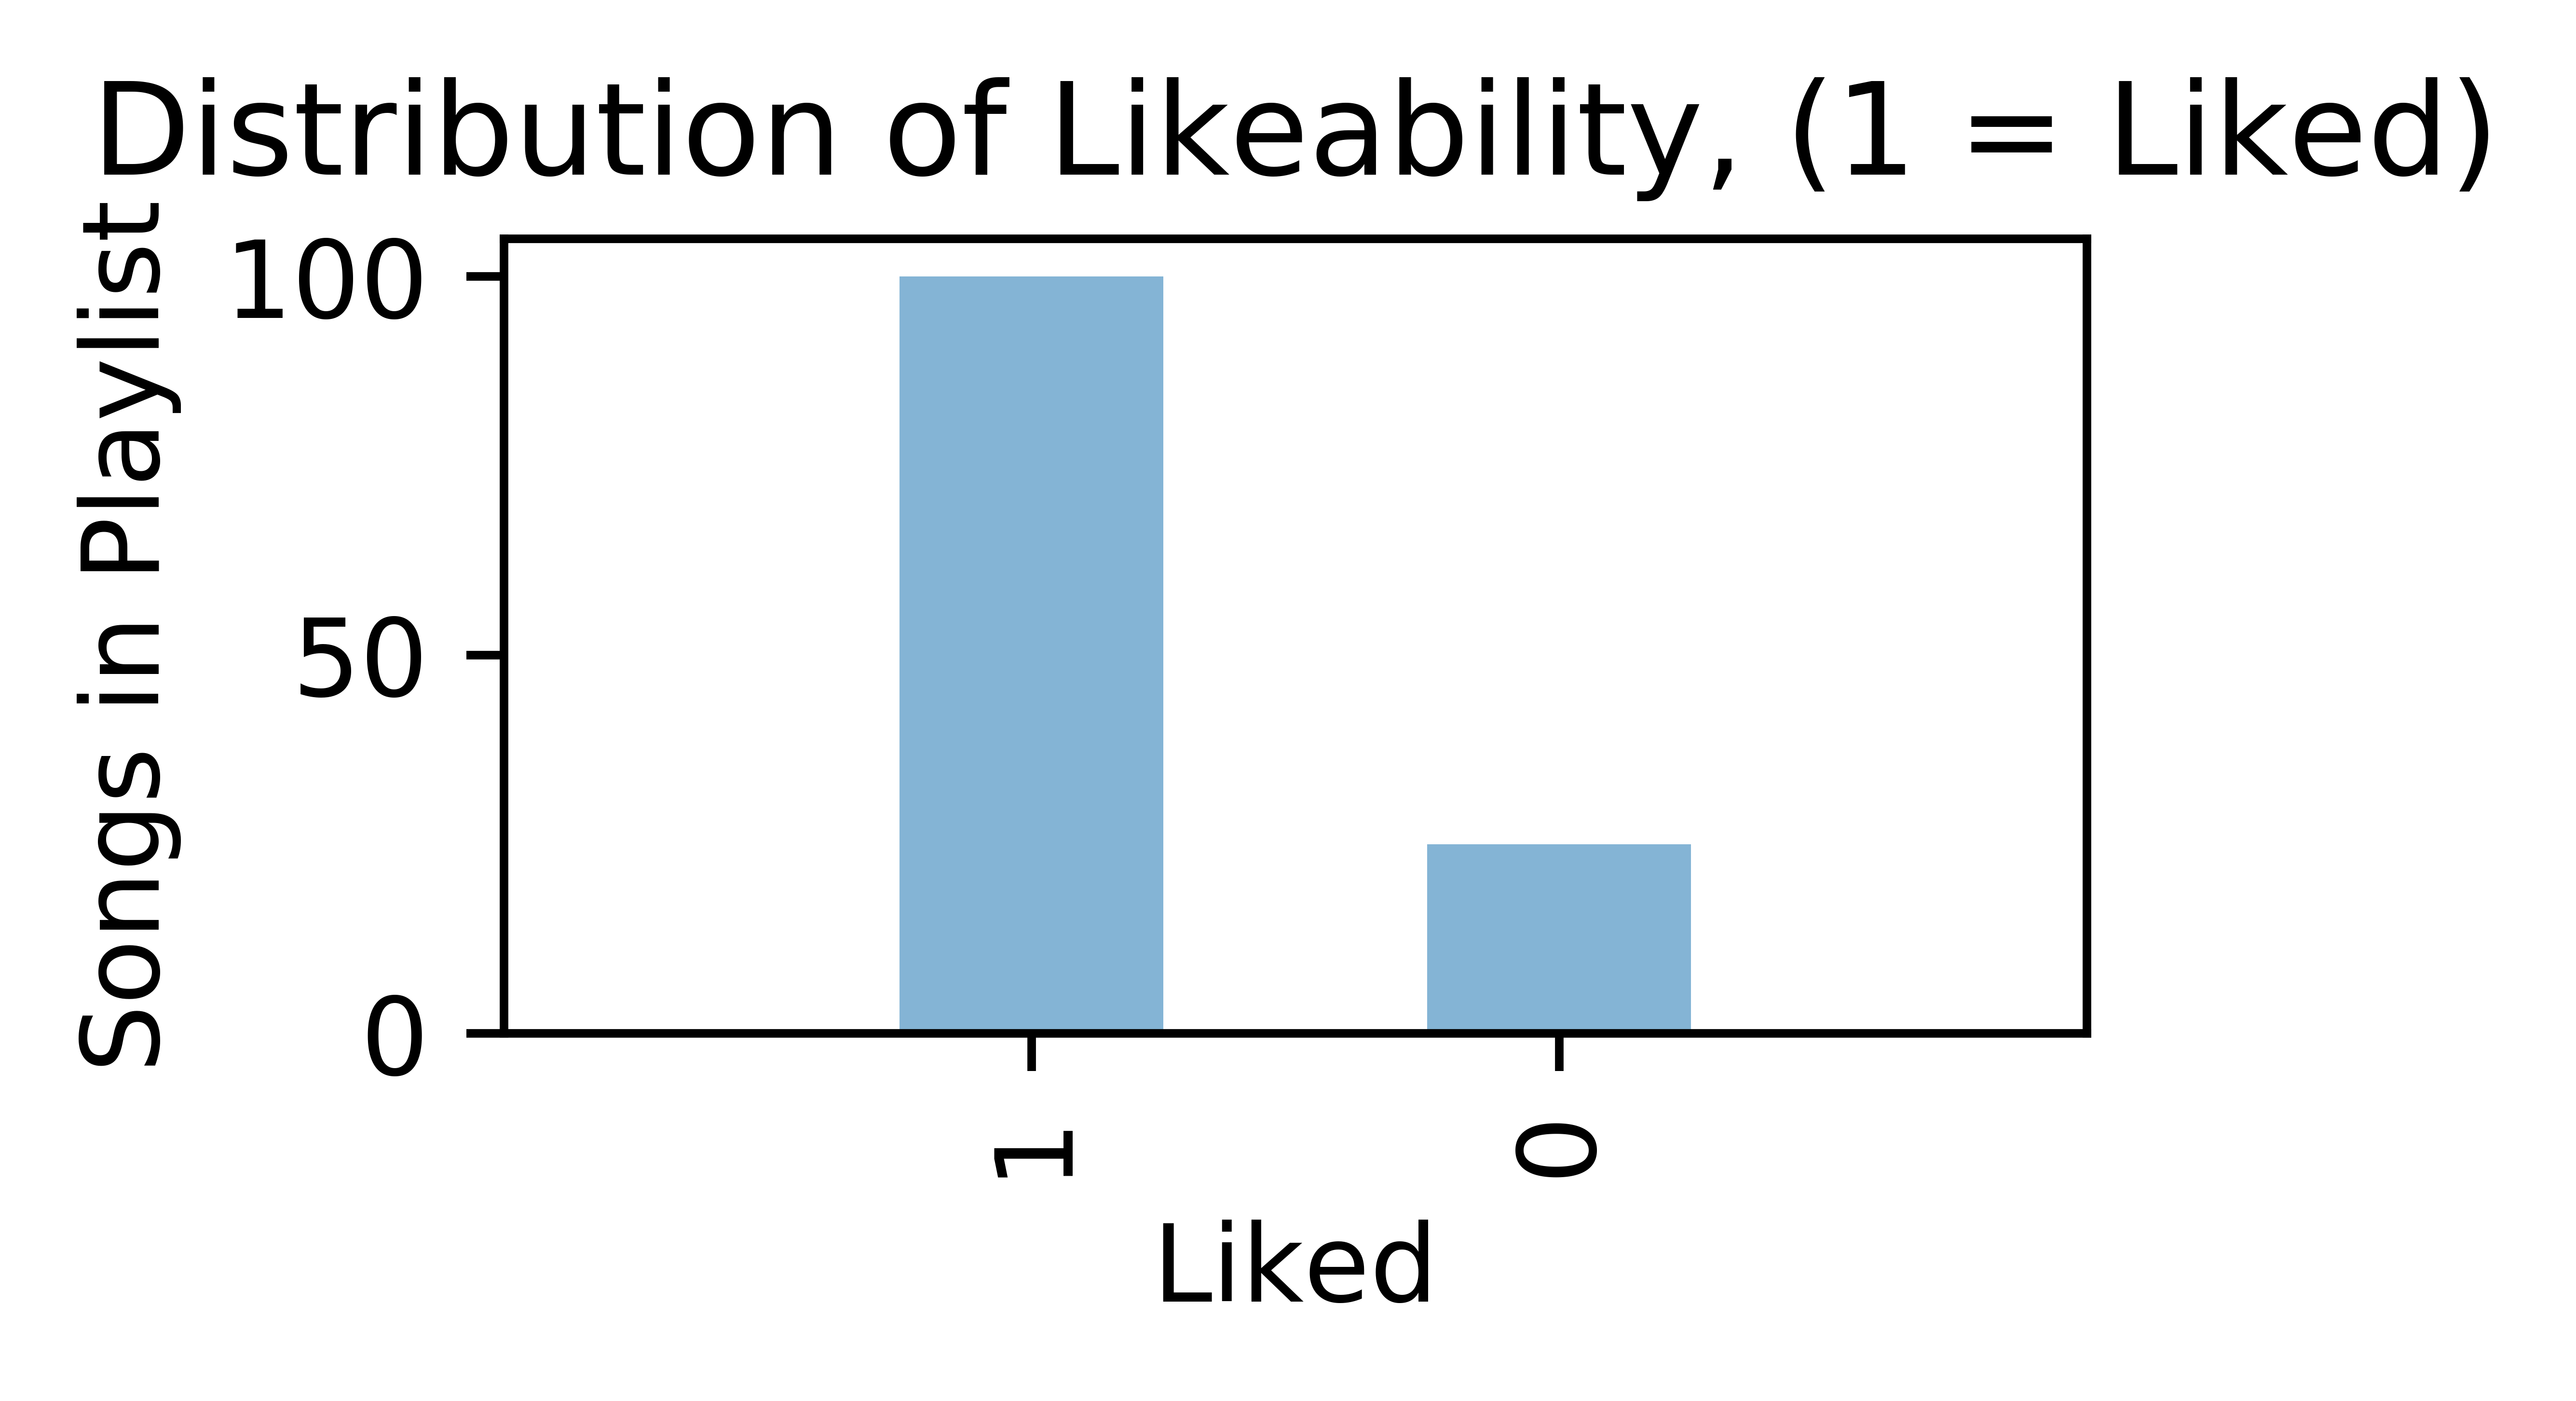

In [7]:
fig = plt.figure(figsize=(9,3), dpi=1600) 
alpha_bar_chart = 0.55 
ax1 = plt.subplot2grid((2,3),(0,0))               
train.likeability.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax1.set_xlim(-1, 2)
plt.ylabel("Songs in Playlist")
plt.xlabel("Liked")
plt.title("Distribution of Likeability, (1 = Liked)")

In [8]:
train['likeability'].value_counts()

1    100
0     25
Name: likeability, dtype: int64

In [9]:
print(round(100/(125),2)*100, "% of the songs liked in selected playlist.")

80.0 % of the songs liked in selected playlist.


Here is a represntation of the number of liked songs in my playlist compared to the number of disliked songs. Our training data set has 80% liked songs and 20% disliked. We are using both liked and disliked as a way to show our model what features of a song are more important for determining likeability. 

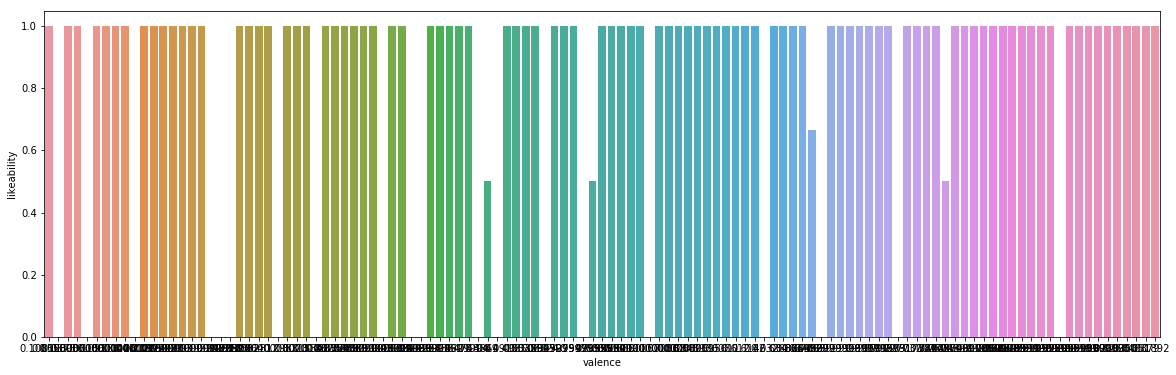

In [10]:
fig, axis1 = plt.subplots(1,1,figsize=(20,6))
average_valence = train[["valence", "likeability"]].groupby(['valence'],as_index=False).mean()
sns.barplot(x='valence', y='likeability', data=average_valence)

I like this representation because its a graph of the valence with likeability. Valence in this set represents the amount of positivity a song portrays. SO from this graphic is shows that the songs I do like are on the extremes of the emotions they portray. There are a few gaps and there are some half bars which means there are songs that portray the same emotion, yet for some reason, are not all liked. 

In [11]:
target = train['likeability']
train = train.drop(['likeability'], axis = 1)

We are now assigning likeability as the factor we are trying to predict. We have to drop the variable so the model recognizes what we need to compare to in order to determine accuracy and precision. 

In [12]:
test.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
dtype: int64

# Building Our Model:

In [13]:
scaler = StandardScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

scaler.fit(test)
scaled_test = scaler.transform(test)

After checking to make sure we have no missing values in the test data which is a selection of 5 full albums including Miles Davis' Bitches Brew, Weather Report's Heavy Weather, Herbie Hancock's Head Hunters, Sonny Rollins' Saxophone Colossus, and Stan Getz's Getz/Gilberto. We are now on our way to begin building a model, but first, we have to scale our data. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train, target, test_size=0.2, random_state=42)

In order to build effective models, we need to grab samples from our training data to act as "mini-training" data which allows us to check for over-fitting before we run it with our real testing data. 

In [15]:
def evaluation_metrics(y_train, y_test, train_predictions, test_predictions):
    rounding = 2
    print('Accuracy:')
    print("  Train: {}".format(round(accuracy_score(y_train, train_predictions),rounding)), "  Test: {}".format(round(accuracy_score(y_test, test_predictions),rounding)))

    print('Precision:')
    print("  Train: {}".format(round(precision_recall_fscore_support(y_train, train_predictions)[0][0],rounding)), "  Test: {}".format(round(precision_recall_fscore_support(y_test, test_predictions)[0][0],rounding)))

In [16]:
def precision_recall_curves(model, X, Y):
    train_prediction_probabilities = model.predict_proba(X)
    train_probs_for_actual_1 = [train_prediction_probabilities[i][1] for i, truth in enumerate(Y) if truth == 1]
    train_probs_for_actual_0 = [train_prediction_probabilities[i][1] for i, truth in enumerate(Y) if truth == 0]
    plt.hist(train_probs_for_actual_1, label='1')
    plt.hist(train_probs_for_actual_0, label='0')
    plt.legend(loc='upper left')
    plt.title("Precision Recall Curve")
    plt.xlabel("Probability")

In [17]:
lr = linear_model.LogisticRegression(penalty='l2')
lr.fit(X_train, y_train)
lr_train_predictions = lr.predict(X_train)
lr_test_predictions = lr.predict(X_test)

In [18]:
evaluation_metrics(y_train, y_test, lr_train_predictions, lr_test_predictions)

Accuracy:
  Train: 0.95   Test: 0.88
Precision:
  Train: 0.94   Test: 0.67


Our first model is a logistic regression. We are getting some pretty good numbers for our training and testing data, but there are other models we can use to raise the testing scores. 

Text(0.5,1,'Coefficients: Logistic Classifier')

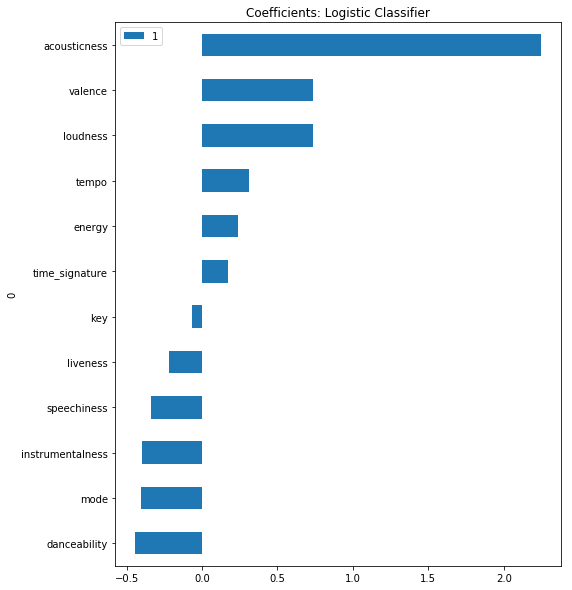

In [19]:
df = pd.DataFrame(sorted(list(zip(train.columns, lr.coef_[0])), key=lambda x: x[1]))
df.index = df[0]
df = df.drop([0], axis = 1)

# Create a bar chart with the coefficients
plt.rcParams['figure.figsize'] = (8.0, 10.0)
df.plot(kind = "barh")
plt.title("Coefficients: Logistic Classifier")

With the logistic regression, we can show visually which features are more important in determining likeability. We see that the top three are: Acousticness, valence, and loudness whereas the least important three are: instrumentalness, mode, and danceability. Honestly, I thought that instrumentalness and danceability would have been more important. 

In [20]:
param_dist = {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 'p': [1, 2, 3]}
model = KNeighborsClassifier()
knn = GridSearchCV(model, param_grid = param_dist, scoring='f1')
knn.fit(X_train, y_train)
knn_train_predictions = knn.predict(X_train)
knn_test_predictions = knn.predict(X_test)

In [21]:
evaluation_metrics(y_train, y_test, knn_train_predictions, knn_test_predictions)

Accuracy:
  Train: 0.86   Test: 0.84
Precision:
  Train: 1.0   Test: 0.5


Next we ran a K-nearest neighbors model and it turns out that our scores got worse. This is a little concerning, but the next models we will use should still do significantly better. 

In [22]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_train_predictions = nb.predict(X_train)
nb_test_predictions = nb.predict(X_test)

In [23]:
evaluation_metrics(y_train, y_test, nb_train_predictions, nb_test_predictions)

Accuracy:
  Train: 0.9   Test: 0.92
Precision:
  Train: 0.82   Test: 1.0


Our next model is the Gaussian Naive Bayes which is showing better results. However, we can still do better. 

In [24]:
param_dist = {"C": [0.2, 0.5, 0.7], "kernel": ['linear', 'poly', 'rbf'], 'degree': [1,2,3]}
model = SVC()
svm = GridSearchCV(model, param_grid = param_dist, scoring='f1')
svm.fit(X_train, y_train)
svm_train_predictions = svm.predict(X_train)
svm_test_predictions = svm.predict(X_test)
print("Best Params: {}".format(svm.best_params_))

Best Params: {'C': 0.7, 'degree': 1, 'kernel': 'linear'}


In [25]:
evaluation_metrics(y_train, y_test, svm_train_predictions, svm_test_predictions)

Accuracy:
  Train: 0.95   Test: 0.88
Precision:
  Train: 0.94   Test: 0.67


We tried the SVC model which brought up our scores for the training data, but then our testing scores fell. This could be because of the sample pulled was more related or easy to determine. Let's press on. 

In [26]:
param_dist = {"criterion": ['gini', 'entropy']}
model = DecisionTreeClassifier()
dt = GridSearchCV(model, param_grid = param_dist, scoring='f1')
dt.fit(X_train, y_train)
dt_train_predictions = dt.predict(X_train)
dt_test_predictions = dt.predict(X_test)
print("Best Params: {}".format(dt.best_params_))

Best Params: {'criterion': 'entropy'}


In [27]:
evaluation_metrics(y_train, y_test, dt_train_predictions, dt_test_predictions)

Accuracy:
  Train: 1.0   Test: 0.92
Precision:
  Train: 1.0   Test: 1.0


In [28]:
train_dt = pd.read_csv(train_location)
test_dt = pd.read_csv(test_location)

scaler = StandardScaler()
scaler.fit(train)
scaled_train_dt = scaler.transform(train)

scaler.fit(test)
scaled_test_dt = scaler.transform(test)

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(scaled_train_dt, target, test_size=0.2, random_state=42)

In [29]:
param_dist = {"criterion": ['gini', 'entropy']}
model = DecisionTreeClassifier()
dto = GridSearchCV(model, param_grid = param_dist, scoring='f1')
dto.fit(X_train_dt, y_train_dt)
dto_train_predictions = dto.predict(X_train_dt)
dto_test_predictions = dto.predict(X_test_dt)

In [30]:
evaluation_metrics(y_train_dt, y_test_dt, dto_train_predictions, dto_test_predictions)

Accuracy:
  Train: 1.0   Test: 0.92
Precision:
  Train: 1.0   Test: 1.0


Running these two decision tree models show us better results, I am predicting that these numbers will raise even higher when we use the random forest which is a cluster of decision trees. 

In [31]:
param_dist = {"n_estimators": [500, 1000, 2500], "max_depth": [1, 3, 7, 10, 12, 15]}
model = RandomForestClassifier()
rf = GridSearchCV(model, param_grid = param_dist, scoring='f1')
rf.fit(X_train, y_train)
rf_train_predictions = rf.predict(X_train)
rf_test_predictions = rf.predict(X_test)
print("Best Params: {}".format(rf.best_params_))

Best Params: {'max_depth': 12, 'n_estimators': 1000}


In [32]:
evaluation_metrics(y_train, y_test, rf_train_predictions, rf_test_predictions)

Accuracy:
  Train: 1.0   Test: 0.88
Precision:
  Train: 1.0   Test: 1.0


In [33]:
rff = RandomForestClassifier(n_estimators = 2500, max_depth = 7)
rff.fit(X_train, y_train)

feature_imp = sorted(list(zip(train.columns, rff.feature_importances_)), key=lambda x: x[1], reverse=True)

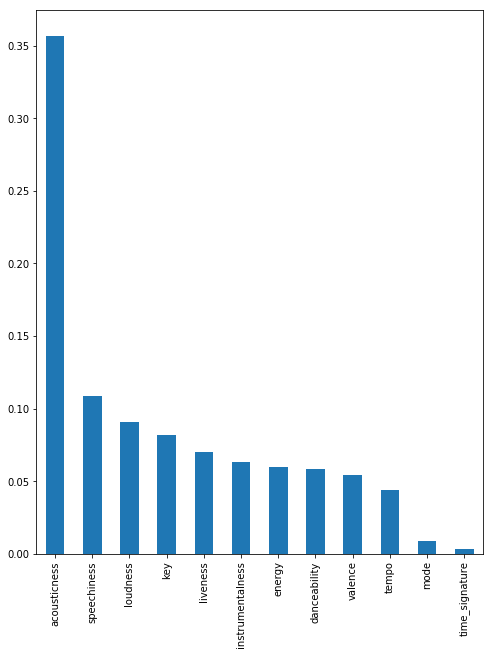

In [34]:
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='bar')

This graph is helping us see feature importance in the random forest model. A few of the more important features have changed except for acousticness. Acousticness has remained the most important feature. 

In [35]:
Y_pred = rf.predict(test)

In [36]:
print (Y_pred)

[1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1
 0 0 0 0 0 0 0]


Well from these numbers, we have the predictions on whether or not I will like the song based on the model. I am averaging these out in their respective albums and seeing if the model recommends the album to me. The only thing left to do is to actually go and listen to test the true accuracy. Hope you have enjoyed this project. Thanks for checking it out! 